In [1]:
from obsidian import Group, Canvas, EQ
from obsidian.geometry import Point, Line, Circle
from obsidian.symbols import Text
from obsidian.infix import RIGHT_BY, ABOVE_BY

from pysmt.shortcuts import And

In [2]:
# spacings, relative positionings, and other "magic" numbers

xpad = 22
ypad = 30
r = 9

l_label_delta = (-5, -6)
r_label_delta = (5, -6)

addr_ypad = ypad

overhang = 7
text_width = 44

constraints = []

In [3]:
# style consts

BLACK = "#000000"
WHITE = "#FFFFFF"
GRAY = "#555555"
RED = "#DD4444"
GREEN = "#66EA86"

LINE_STYLE = {"stroke": BLACK, "stroke_width": 1.5}
BORDER_STYLE = {"stroke": BLACK, "stroke_width": 1, "stroke-dasharray": "3 2"}

In [4]:
# basic abstraction: takes two children, builds a Group containing them + a root node

def tree_node(leaf1, leaf2):
    leaf1_anchor = Point(leaf1.center.x, leaf1.bounds.top_edge)
    leaf2_anchor = Point(leaf2.center.x, leaf2.bounds.top_edge)
    root_anchor = Point((leaf1.center.x + leaf2.center.x) / 2, leaf1.bounds.top_edge - ypad)

    line1 = Line(leaf1_anchor, root_anchor, LINE_STYLE)
    line2 = Line(leaf2_anchor, root_anchor, LINE_STYLE)
    
    label1 = Text("0", font_size=9, anchor_point=line1.center + l_label_delta, style={"fill": BLACK})
    label2 = Text("1", font_size=9, anchor_point=line2.center + r_label_delta, style={"fill": BLACK})

    return Group([leaf1, leaf2, line1, line2, label1, label2], [leaf1.center.y |EQ| leaf2.center.y])

In [5]:
# given a list of root nodes, pairs them off and plugs them into tree_node()

def tree_layer(leaves):
    return [tree_node(a, b) for a, b in zip(leaves[::2], leaves[1::2])]

In [6]:
leaves = [Circle(radius=r, style={"stroke": BLACK, "stroke_width": 0.8, "fill": WHITE}) for _ in range(32)]
constraints += [c2.center.x |EQ| c1.center.x + xpad for c1, c2 in zip(leaves, leaves[1:])]

In [7]:
GREEN_LEAVES = [1, 9, 10, 15, 17]
RED_LEAVES = [6, 13, 18, 20, 23]
ALL_LEAVES = GREEN_LEAVES + RED_LEAVES
for i in RED_LEAVES:
    leaves[i].style["fill"] = RED
for i in GREEN_LEAVES:
    leaves[i].style["fill"] = GREEN

In [8]:
layer_5 = tree_layer(leaves)
layer_4 = tree_layer(layer_5)
layer_3 = tree_layer(layer_4)
layer_2 = tree_layer(layer_3)
layer_1 = tree_layer(layer_2)

In [9]:
def lookup(addr, k):
    return sorted(ALL_LEAVES, key=lambda leaf: addr ^ leaf)[:k]

k1_colors = ["G" if any(leaf in GREEN_LEAVES for leaf in lookup(addr, 1)) else "R" for addr in range(32)]
k2_colors = ["G" if any(leaf in GREEN_LEAVES for leaf in lookup(addr, 2)) else "R" for addr in range(32)]
k3_colors = ["G" if any(leaf in GREEN_LEAVES for leaf in lookup(addr, 3)) else "R" for addr in range(32)]

assert ''.join(k1_colors) == ("GGGG" "RRRR" "GGGG" "RRGG" "GGRR" "RRRR" "GGRR" "RRRR")
assert ''.join(k2_colors) == ("GGGG" "GGGG" "GGGG" "GGGG" "GGGG" "RRRR" "GGGG" "RRRR")
assert ''.join(k3_colors) == ("GGGG" "GGGG" "GGGG" "GGGG" "GGGG" "GGRR" "GGGG" "GGRR")

k1_circles = [Circle(radius=r, style={"stroke_width": 0, "fill": RED if c == "R" else GREEN}) for c in k1_colors]
k2_circles = [Circle(radius=r, style={"stroke_width": 0, "fill": RED if c == "R" else GREEN}) for c in k2_colors]
k3_circles = [Circle(radius=r, style={"stroke_width": 0, "fill": RED if c == "R" else GREEN}) for c in k3_colors]

k_group = Group(
    k1_circles + k2_circles + k3_circles,
    [And(
        leaf.x |EQ| k1.x,
        leaf.x |EQ| k2.x,
        leaf.x |EQ| k3.x,
        leaf.center |ABOVE_BY(addr_ypad)| k1.center,
        k1.center   |ABOVE_BY(addr_ypad)| k2.center,
        k2.center   |ABOVE_BY(addr_ypad)| k3.center,
    ) for leaf, k1, k2, k3 in zip(leaves, k1_circles, k2_circles, k3_circles)]
)

In [10]:
x1 = leaves[0].bounds.left_edge - overhang
x2 = leaves[-1].bounds.right_edge + overhang
x3 = x2 + text_width

y1 = (leaves[0].bounds.bottom_edge + k1_circles[0].bounds.top_edge) / 2
y2 = y1 + addr_ypad
y3 = y2 + addr_ypad
y4 = y3 + addr_ypad

border1 = Line(Point(x1, y1), Point(x3, y1), BORDER_STYLE)
border2 = Line(Point(x1, y2), Point(x3, y2), BORDER_STYLE)
border3 = Line(Point(x1, y3), Point(x3, y3), BORDER_STYLE)
border4 = Line(Point(x1, y4), Point(x3, y4), BORDER_STYLE)
border5 = Line(Point(x2, y1), Point(x2, y4), BORDER_STYLE)

ktext1 = Text("k = 1", 12, Point(x2 + (text_width/2), y1 + (addr_ypad/2) - 2), style={"fill": BLACK})
ktext2 = Text("k = 2", 12, Point(x2 + (text_width/2), y2 + (addr_ypad/2) - 2), style={"fill": BLACK})
ktext3 = Text("k = 3", 12, Point(x2 + (text_width/2), y3 + (addr_ypad/2) - 2), style={"fill": BLACK})

markup = Group([border1, border2, border3, border4, border5, ktext1, ktext2, ktext3])

In [11]:
# give each circle a unique ID so we can add CSS to highlight them on mouseover

def leaf_name(i): return f'tree_leaf_{i}'
def addr_name(i, k): return f'data_addr_k{k}_{i}'

for i, leaf in enumerate(leaves):
    leaf.style['id'] = leaf_name(i)

for i, circle in enumerate(k1_circles):
    circle.style['class'] = 'addr_row_member'
    circle.style['id'] = addr_name(i, k=1)

for i, circle in enumerate(k2_circles):
    circle.style['class'] = 'addr_row_member'
    circle.style['id'] = addr_name(i, k=2)

for i, circle in enumerate(k3_circles):
    circle.style['class'] = 'addr_row_member'
    circle.style['id'] = addr_name(i, k=3)

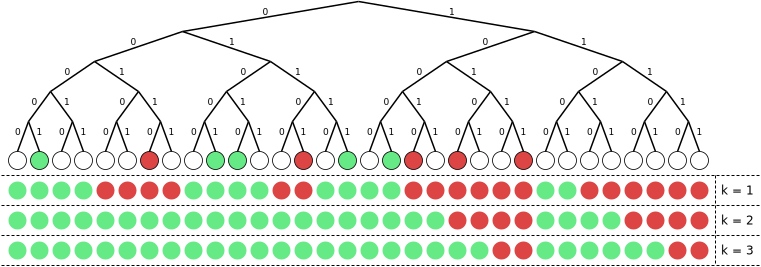

In [12]:
canvas = Canvas(Group([k_group, markup] + layer_1, constraints), margin=3)
canvas.render()
canvas.rendered

In [13]:
canvas.rendered.width, canvas.rendered.height

(761, 267)

In [14]:
canvas.save_png("/tmp/tree.png")
canvas.save_svg("/tmp/tree.svg")

Wrote /tmp/tree.png
Wrote /tmp/tree.svg


In [15]:
# this code generates some CSS to highlight lookup members whenever you mouse over an address

highlight_style = " { stroke-width: 4; stroke: #333333; }"

styles = [".addr_row_member:hover" + highlight_style]

for addr in range(32):
    for k in (1, 2, 3):
        for node in lookup(addr, k):
            styles += [f"#{addr_name(addr, k)}:hover ~ #{leaf_name(node)} {highlight_style}"]

css = "\n".join(styles)

from IPython.display import display, HTML
display(HTML("<style>" + css + "</style>"))

with open("/tmp/sybil-prefix-tree.css", "w") as f:
    f.write(css)